# Wikipedia Articles NLP Project

## Overview

This notebook performs an NLP on random articles collected from [Wikipedia](https://en.wikipedia.org/). It explored different feature extraction and clustering methods.

## Imports

In [56]:
import gensim.downloader as model_api
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import time
import torch
import umap

## Data Collection

In [2]:
url = 'https://en.wikipedia.org/w/api.php'
#csv_path = 'data/wiki_articles.csv'
csv_path = 'wiki_articles.csv'

In [49]:
def get_random_titles(n:int) -> np.array:
    titles = []
    while len(titles) < n:
        try:
            params = {
                'action': 'query',
                'list': 'random',
                'rnnamespace': 0,  # Only articles
                'rnlimit': min(50, n - len(titles)),
                'format': 'json'
            }
            response = requests.get(url, params=params)
            data = response.json()
            batch = [item['title'] for item in data['query']['random']]
            titles.extend(batch)
            time.sleep(0.5)
        except Exception as e:
            print('Error:', e)
            time.sleep(1)
    return np.array(titles)

In [50]:
def get_article_text(title:str) -> str:
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'extracts',
        'explaintext': True,
        'titles': title
    }
    try:
        response = requests.get(url, params=params)
        pages = response.json()['query']['pages']
        page = next(iter(pages.values()))
        return page.get('extract', '')
    except Exception as e:
        print(f'Error fetching {title}: {e}')
        return ''

In [51]:
def remove_unwanted_sections(text):
    unwanted_sections = [
        r'==\s*See also\s*==',
        r'==\s*References\s*==',
        r'==\s*Further reading\s*==',
        r'==\s*External links\s*==',
        r'==\s*Notes\s*==',
        r'==\s*Sources\s*==',
        r'==\s*Bibliography\s*==',
        r'==\s*Footnotes\s*=='
    ]

    pattern = re.compile('|'.join(unwanted_sections), re.IGNORECASE)
    match = pattern.search(text)

    if match:
        return text[:match.start()].strip()
    else:
        return text.strip()

In [52]:
def full_clean(text):
    core = remove_unwanted_sections(text)
    core = re.sub(r'\n{2,}', '\n', core)
    return core.strip()

In [53]:
def export_list_to_csv(data:list[dict], csv_path:str) -> None:
	df = pd.DataFrame(data)
	if not os.path.isfile(csv_path):
		df.to_csv(csv_path, index=False)
	else:
		df.to_csv(csv_path, index=False, header=False, mode='a')

In [ ]:
# Get 10000 random articles from Wikipedia
titles = get_random_titles(10000)
chunks = np.array_split(titles, 100)

In [ ]:
# Export data in chunks
for i, chunk in enumerate(chunks):
	print(f'Chunk {i + 1}/{len(chunks)}')
	wiki_list = []
	for title in chunk:
		text = get_article_text(title)
		if text and len(text) > 300:  # Filter out very short pages
			wiki_list.append({
				'title': title,
				'text': full_clean(text)
			})
		time.sleep(0.5) # Sleep for 500 ms to avoid rate-limiting
	export_list_to_csv(wiki_list, csv_path)
	print(f'Added {len(wiki_list)}/{len(chunk)} articles to CSV file.')

## EDA

In [4]:
# Load data
df = pd.read_csv(csv_path)
df.head()

,title,text
0,Biff Schlitzer,"Victor Joseph ""Biff"" Schlitzer (December 4, 18..."
1,Prabhash Kumar,"Prabhash Kumar is an Indian politician, farmer..."
2,San Carlos Formation,The San Carlos Formation is a geological forma...
3,2023 in Ohio,The following is a list of events of the year ...
4,2009 Iowa special elections,The 2009 Iowa state special elections were hel...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8595 entries, 0 to 8594
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8595 non-null   object
 1   text    8595 non-null   object
dtypes: object(2)
memory usage: 134.4+ KB


In [7]:
# Get smallest text
index = df['text'].str.len().idxmin()
df.iloc[index]

,5992
title,List of volcanoes in El Salvador
text,This is a list of active and extinct volcanoes...


In [5]:
# Get biggest text
index = df['text'].str.len().idxmax()
df.iloc[index]

,5321
title,Divided differences
text,"In mathematics, divided differences is an algo..."


## Data Preprocessing

### GloVe

In [8]:
# Tokenize texts by removing punctuation and special characters
# and lowercasing everything
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k),v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

words = df['text'].str.replace(pattern, replacer, regex=True).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [9]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [10]:
# Function to retrieve the word vector or return a zero vector if the word is not found
def get_word_vector(word):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(word_vectors.vector_size)

# Function to map a text to its vector representation by summing the word vectors
def map_text_to_vector(page):
    return np.sum([get_word_vector(word) for word in page if pd.notna(word)], axis=0)

# Apply the mapping function to each text and create a DataFrame of the results
glove_emb = pd.DataFrame(words.apply(map_text_to_vector, axis=1).tolist())
glove_emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-25.553197,61.277992,-6.441907,-1.327819,33.129767,25.303264,-93.681521,-16.925939,-39.743567,-34.605831,...,-31.948293,-17.013292,7.921901,-10.060203,-43.326178,41.130120,-28.867548,-40.196636,-8.029011,-6.774925
1,1.704619,-1.517041,-13.325157,5.417937,20.572402,23.046139,-10.669863,-4.731333,-16.040038,-24.081318,...,-27.581619,14.695299,-22.071071,-11.928519,-20.945080,10.538783,-21.423375,-22.582989,19.028705,-20.659330
2,17.696770,2.319915,-2.985669,5.802332,11.713197,3.547520,-16.159113,-15.404687,-11.138138,-3.644905,...,-26.690475,-17.304464,2.805483,2.516293,0.250916,5.042878,6.546632,-9.455825,2.516218,-19.384553
3,57.877136,42.455009,17.792969,-2.447541,9.637690,54.997059,-98.312935,5.448763,0.324308,-72.113289,...,-66.280624,-2.030703,29.818583,-25.870623,-49.491760,43.662933,-53.715706,-36.119362,10.410617,-42.222218
4,4.474286,20.002575,7.467521,10.103029,37.283440,48.269833,-125.686661,-12.588920,-42.947601,-100.732811,...,-80.048775,35.040638,-52.696964,-45.672440,-89.739273,49.484070,-88.131134,-34.871624,8.551754,27.011698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,14.352584,122.384755,-170.521032,-47.543207,33.140047,40.247651,-144.909884,17.184558,-138.784235,-16.838819,...,-45.112582,18.165843,-47.235383,-89.321172,-80.017884,43.918467,-65.476791,-84.576976,-123.467156,-24.511413
8591,186.930886,-73.040578,-125.070949,37.098090,223.528212,191.890156,-199.127123,-234.222369,-46.272845,37.687762,...,22.619779,59.103097,-3.399424,27.933238,331.744119,261.918040,-57.953918,-41.787180,-38.495136,-91.641842
8592,15.554881,26.999107,-32.302677,-13.859942,20.643557,-5.603209,-58.670879,-1.185496,-48.660622,-19.573153,...,-22.711718,4.816690,-11.640561,-36.836224,-58.727997,22.536022,-32.802155,-52.557323,16.080572,-19.773840
8593,53.355042,-24.083059,-6.758219,-5.503126,61.069004,32.600834,-51.542694,7.272554,-10.884201,-61.907169,...,-72.853905,36.391407,35.984333,-12.220505,-5.377378,25.349607,-92.599640,-37.820564,24.898485,-86.716850


### Sentence Transformer

In [11]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
# Calculate embeddings
mini_emb = pd.DataFrame(model.encode(df['text']))
mini_emb

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.023374,0.023269,-0.103945,-0.033877,0.031884,0.100352,-0.051282,0.155663,-0.035584,0.051362,...,-0.053423,-0.014926,-0.045564,-0.063073,0.016583,-0.078675,0.018316,-0.048807,-0.053580,-0.006450
1,0.001867,-0.012857,-0.052250,-0.035741,0.041092,0.021050,0.093268,-0.023004,-0.087791,0.028738,...,-0.052659,0.017524,-0.082142,-0.061607,-0.000720,0.023933,0.108369,0.060540,-0.015630,-0.011093
2,-0.051594,0.027089,-0.045995,0.067701,-0.045514,-0.002171,-0.086146,-0.015811,-0.035470,-0.026100,...,0.005135,0.006779,0.050991,0.040364,-0.004147,0.011562,-0.047039,0.027455,0.086669,-0.001813
3,-0.006973,0.010959,0.037496,0.016119,0.095530,0.044021,-0.007896,0.041771,-0.131271,0.058207,...,0.041905,0.019995,-0.004059,-0.129669,0.002306,-0.022474,-0.031808,0.017117,0.007192,0.009654
4,-0.046682,-0.012143,0.086666,-0.046343,0.007200,0.052154,-0.024122,0.040913,0.006559,0.040980,...,-0.044681,-0.068946,-0.053276,-0.181910,0.004719,0.064600,0.025116,0.041235,0.016052,-0.075555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,0.008887,0.017314,-0.041147,-0.014189,-0.073766,0.079026,-0.019779,0.052027,-0.037399,0.011336,...,0.018744,-0.022396,-0.025683,0.030633,0.007230,-0.019306,0.007542,0.079803,-0.048633,-0.000934
8591,-0.013043,-0.084558,-0.066673,0.016100,0.024330,-0.031969,0.008016,-0.021110,0.055534,-0.042198,...,-0.031272,0.039986,0.023300,-0.063697,0.106172,-0.044735,-0.046021,0.077347,0.082478,0.018576
8592,0.056743,-0.016630,-0.045755,0.021144,-0.031342,-0.050017,-0.061236,0.062345,0.089322,-0.009769,...,-0.092888,0.007519,0.099991,0.052765,0.022278,0.003323,-0.021144,-0.013760,-0.052189,-0.044215
8593,0.059751,0.089780,-0.048822,0.020530,0.057927,0.023562,0.012857,0.002716,0.015486,0.049756,...,0.021733,0.056091,0.006063,-0.078170,0.012723,-0.022446,0.086766,-0.044068,0.004002,-0.003946


## Unsupervised Learning

Three different clustering methods will be explored. The best one will be selected for analyzing and visualization.

### K-Means

Two metrics will be used to determine the optimal k: **Sum of Squared Distances (SSD)** and the **Silhouette Score**. The same metrics will be used to determine the best feature extraction technique.

#### Find optimal K

In [39]:
def create_models(data:pd.DataFrame) -> pd.DataFrame:
  models = []
  for k in range(2, 31):
      kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
      kmeans.fit(data)
      labels = kmeans.labels_
      models.append({
          'k': k,
          'ssd': kmeans.inertia_,
          'silhouette': silhouette_score(data, labels, metric='euclidean'),
      })

  models_df = pd.DataFrame(models).set_index('k')
  return models_df

In [45]:
def display_k_plots(data:pd.DataFrame, technique:str) -> None:
  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True)

  # Elbow Method
  kneedle = KneeLocator(data.index, data['ssd'], curve='convex', direction='decreasing')
  optimal_k = kneedle.elbow
  optimal_score = data.loc[optimal_k, 'ssd']
  ax1.plot(data['ssd'], marker='s')
  ax1.set_ylabel('SSD')
  ax1.axvline(x=optimal_k, color='black', linestyle='--')
  ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

  # Silhouette Score
  optimal_k = data['silhouette'].idxmax()
  max_score = data['silhouette'].max()
  ax2.plot(data['silhouette'], marker='s')
  ax2.set_xlabel('k')
  ax2.set_ylabel('Silhouette Score')
  ax2.axvline(x=optimal_k, color='black', linestyle='--')
  ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

  fig.suptitle(f'Different Metrics for Optimal K ({technique})')
  fig.tight_layout()
  plt.show()

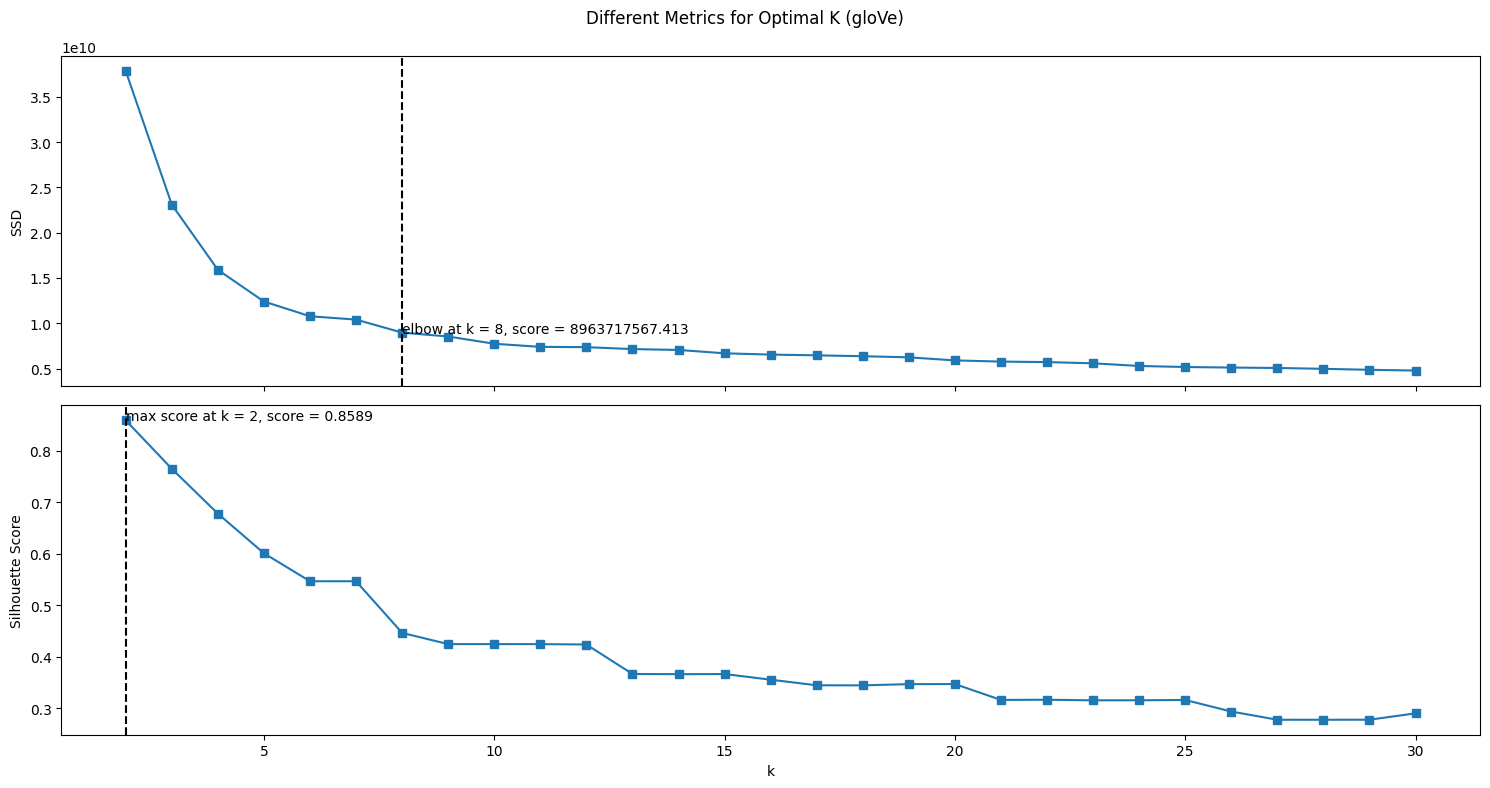

In [46]:
# Display plots for gloVe
metrics_df = create_models(glove_emb)
display_k_plots(metrics_df, 'gloVe')

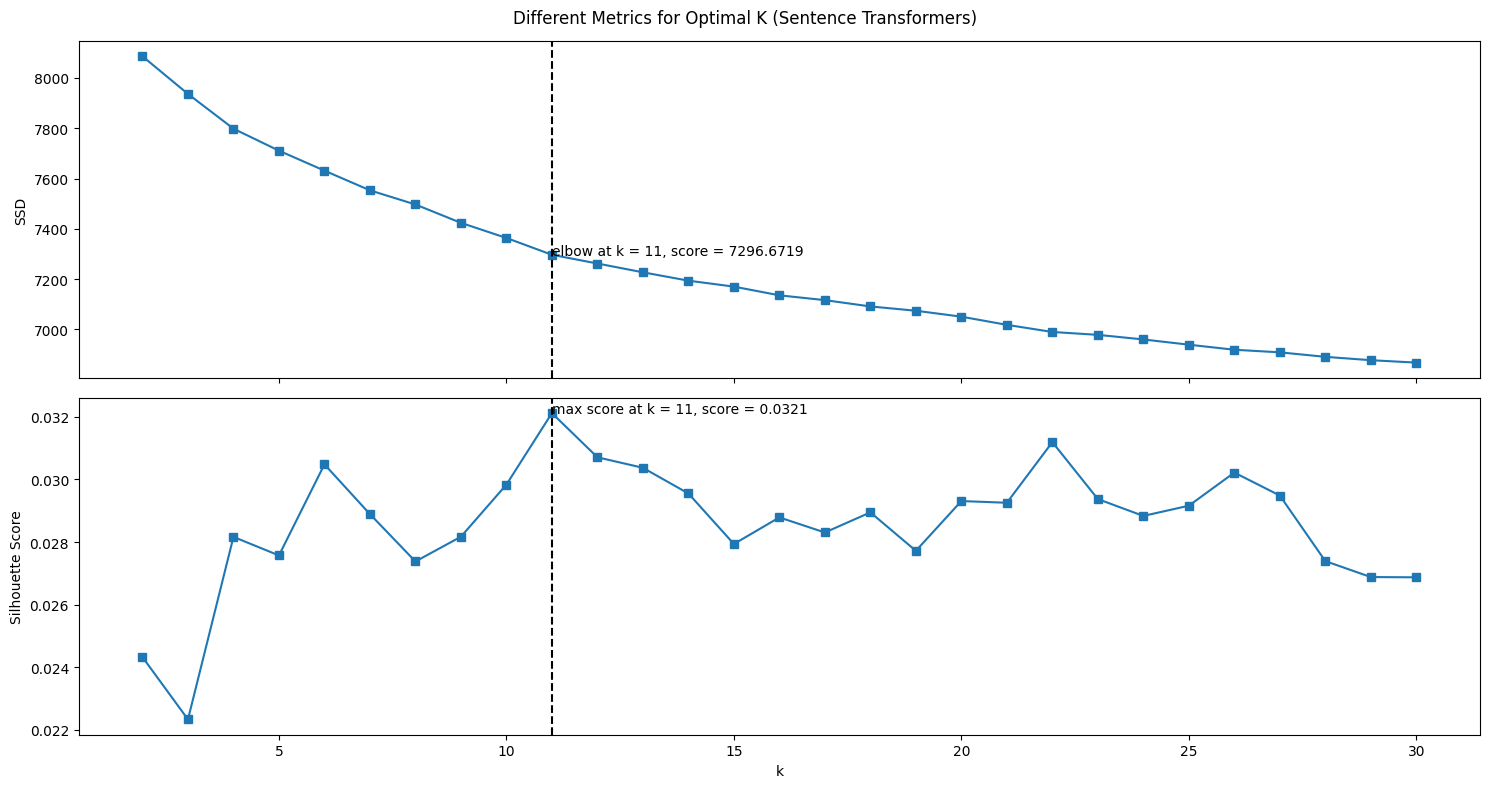

In [48]:
# Display plots for all-MiniLM-L6-v2
metrics_df = create_models(mini_emb)
display_k_plots(metrics_df, 'Sentence Transformers')

When calculating the optimal k value for the sentence transformers embeddings, the same optimal k value is found for both metrics. It seems that the sentence transformers performs better than GloVe. Also, 11 seems to be a reasonable number of clusters. The embeddings calculated with the sentence transformer will be used for the 2 other clustering methods.

#### Fit model

In [54]:
# Optimal k
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(mini_emb)

KMeans(n_clusters=11, random_state=42)

In [57]:
# Add labels to dataframes
labels = kmeans.labels_
df.insert(0, 'cluster', labels)

#### Analyse Clusters

In [71]:
cluster0 = df[df['cluster'] == 0]
cluster0.sample(10)

,cluster,title,text
8457,0,Kushi (Utamaro),"Kushi (櫛, ""Comb"", c. 1795–96) is a title given..."
6896,0,"Government College for Women, Baramulla",Government College for Women Baramulla commonl...
1050,0,Phra Malai,"Phra Malai Kham Luang (Thai: พระมาลัยคำหลวง, p..."
1734,0,Sayed Kashua,"Sayed Kashua (Arabic: سيد قشوع, Hebrew: סייד ק..."
4418,0,Barrobo District,"Barrobo District is a district of Liberia, one..."
4176,0,Hyehwamun,"Hyehwamun (Korean: 혜화문), also known as Northea..."
5484,0,"Pathariya, Bhopal",Pathariya is a village in the Bhopal district ...
7787,0,Egmore metro station,Egmore Metro is an underground metro station o...
5136,0,Muhammad al-Muqri,Haj Muhammad Ben Abdessalam al-Muqri (Arabic: ...
2304,0,Roselina Tirkey,Roselina Tirkey (born 1 May 1982) is an Indian...


In [70]:
cluster1 = df[df['cluster'] == 1]
cluster1.sample(10)

,cluster,title,text
2569,1,Metapellobunus,Metapellobunus is a genus of harvestmen in the...
2766,1,Ammannia coccinea,Ammannia coccinea is a species of flowering pl...
2175,1,Odostomia kadiakensis,Odostomia kadiakensis is a species of sea snai...
1899,1,Megalomycter,Megalomycter teevani is a species of fish in t...
692,1,Pangalliformes,Pangalliformes is the scientific name of a pro...
4603,1,Atopomyrmex,Atopomyrmex is a small genus of arboreal ants ...
7893,1,Synothele moonabie,Synothele moonabie is a species of mygalomorph...
3307,1,Alvania algeriana,Alvania algeriana is a species of minute sea s...
1335,1,Armada (moth),Armada is a genus of moths of the family Noctu...
8280,1,Heterolepis,Heterolepis is a genus of flowering plants in ...


In [73]:
cluster2 = df[df['cluster'] == 2]
cluster2.sample(10)

,cluster,title,text
7427,2,Jorge Rojas (Paraguayan footballer),Jorge Luis Rojas Mendoza (born 7 January 1993)...
2994,2,Sanctuary of the Madonna of Miracles (Corbetta),The Sanctuary of Madonna of Miracles (known of...
3825,2,Loca juventud,Loca juventud is a 1965 Spanish and Italian fi...
2904,2,Guillaume Depardieu,Guillaume Jean Maxime Antoine Depardieu (7 Apr...
8312,2,Pedro Porro,Pedro Antonio Porro Sauceda (Spanish pronuncia...
475,2,Fantcha,Fantcha (born Francelina Durão Almeida on Octo...
246,2,Arena Recife-Olinda,The Arena Recife-Olinda is a new football stad...
5623,2,Luigi Scevola,"Luigi Scevola (born Brescia, 1770 – died Milan..."
7475,2,Menjívar,Menjívar or Menjivar is a Spanish surname. It ...
1498,2,100% Banco,100% Banco is a privately owned commercial ban...


In [74]:
cluster3 = df[df['cluster'] == 3]
cluster3.sample(10)

,cluster,title,text
1452,3,Lukas Bärfuss,Lukas Bärfuss (born 30 December 1971) is a Swi...
5471,3,John Iadarola,"John Iadarola (born February 5, 1983) is a lef..."
2908,3,Mairead Curran,Mairead Curran (born 16 August 1968) is an Aus...
2050,3,Penny Ramsey,Penny Ramsey (25 June 1947 – 11 February 2009)...
1156,3,Lady Rowlands,"Lady Rowlands (born Mary Allen Neal; April 12,..."
4380,3,Santerians,The Santerians are a fictional superhero team ...
2786,3,Angel (novel),Angel is a novel by the English novelist Eliza...
3545,3,Professor Popper's Problem,Professor Popper's Problem is a 1975 British c...
7077,3,Cadwell Turnbull,Cadwell Turnbull is an American science fictio...
5315,3,The Year's Best Science Fiction: Sixteenth Ann...,The Year's Best Science Fiction: Sixteenth Ann...


In [75]:
cluster4 = df[df['cluster'] == 4]
cluster4.sample(10)

,cluster,title,text
5924,4,David Quinn (ice hockey),"David Quinn (born July 30, 1966) is an America..."
2827,4,1972 Alcorn A&M Braves football team,The 1972 Alcorn A&M Braves football team repre...
3180,4,Baseball5,Baseball5 (B5 or BB5) is a simplified variatio...
4117,4,1898 Montana Agricultural football team,The 1898 Montana Agricultural football team wa...
7410,4,Makan Aïko,Makan Aïko (born 7 July 2001) is a French foot...
1248,4,Scott Curry (American football),"Scott Curry (born December 25, 1975) was an Am..."
1675,4,Atlantic Division (NBA),The Atlantic Division is one of the three divi...
1845,4,Roy Burton,"Roy Burton (born 13 March 1951 in Wantage, Ber..."
6450,4,Willard Bruguier,"Willard Bruguier III ( born December 4, 1981) ..."
222,4,"George Ward (footballer, born 1889)",George Grant Ward (4 July 1889 – 18 February 1...


In [76]:
cluster5 = df[df['cluster'] == 5]
cluster5.sample(10)

,cluster,title,text
6655,5,The Eighth (album),The Eighth is a live album by Cecil Taylor rec...
3905,5,Molinos (album),Molinos is the third studio album by Canadian ...
5370,5,Vintage (disambiguation),Vintage is a process or quality in wine-making...
8422,5,Michael White (clarinetist),"Michael White (born November 29, 1954, in New ..."
5887,5,Nirai Kanai (Cocco song),"""Nirai Kanai"" (ニライカナイ) is a song by Japanese s..."
6588,5,Gumbo'!,Gumbo'! is a studio album by American artist P...
138,5,Nipplepeople,Nipplepeople (stylised in lowercase) is a Croa...
102,5,Waltzing in a Dream,"""Waltzing in a Dream"" is a 1932 song recorded ..."
2246,5,Tomorrow (manhwa),Tomorrow (Korean: 내일; RR: Naeil) is a South Ko...
431,5,Endel Rivers,"Endel Rivers (born Endel Jõgi; 15 April 1959, ..."


In [77]:
cluster6 = df[df['cluster'] == 6]
cluster6.sample(10)

,cluster,title,text
5788,6,Raceland-Worthington Independent School District,Raceland-Worthington Independent School Distri...
2455,6,"Martin City, Montana",Martin City is an unincorporated community and...
1689,6,Corning Commercial Historic District,The Corning Commercial Historic District is a ...
2712,6,Nickel Plate Glass Company,The Nickel Plate Glass Company was a manufactu...
7347,6,"Wappocomo (Romney, West Virginia)",Wappocomo is a late 18th-century Georgian mans...
805,6,Moneydig Presbyterian Church,Moneydig Presbyterian Church is a church build...
7042,6,List of parks in San Francisco,This is a List of parks in San Francisco\n== F...
2200,6,Bensenville station,Bensenville is a station on Metra's Milwaukee ...
6840,6,"Church of Reconciliation, Leipzig",The Church of Reconciliation (German: Versöhnu...
4729,6,Florence High School,Florence High School may refer to:\nFlorence H...


In [82]:
cluster7 = df[df['cluster'] == 7]
cluster7.sample(10)

,cluster,title,text
6906,7,Unification Day (Cameroon),Unification Day (French: Journée de l'unificat...
8182,7,History of Landsbanki,"In establishing Landsbanki, the Icelandic parl..."
7895,7,Transporter erector,A transporter erector (TE) is a mobile system ...
19,7,18-electron rule,The 18-electron rule is a chemical rule of thu...
547,7,County Court Business Centre,The County Court Business Centre (CCBC) is a c...
3151,7,Keyword-driven testing,"Keyword-driven testing, also known as action w..."
2823,7,Representativity (politics),Representativity is a measure of how well a d...
4749,7,CPTM Series 9500,The CPTM Series 9500 is a class of electric mu...
2145,7,NTF,NTF may refer to:\n== Biology ==\nNeurotrophic...
6788,7,Tower crane anti-collision system,A tower crane anti-collision system is an oper...


In [83]:
cluster8 = df[df['cluster'] == 8]
cluster8.sample(10)

,cluster,title,text
1380,8,"Postołowo, Pomeranian Voivodeship",Postołowo [pɔstɔˈwɔvɔ] is a village in the adm...
78,8,Hans Kampffmeyer (1876–1932),Hans Kampffmeyer (30 January 1876 in Naumburg ...
330,8,Korniyenko,Korniyenko or Kornienko (Ukrainian: Корнієнко ...
5129,8,Katyn Commission,The Katyn Commission or the International Katy...
855,8,Bo Berndtsson,"Bo Berndtsson (born 24 December 1950), is a Sw..."
1231,8,Alexandra Szacka,Alexandra Szacka is a Canadian television jour...
3850,8,Khek Vandy,"Khek Vandy (Khmer: ខែក វ៉ាន់ឌី, 26 September 1..."
7166,8,Claudia van den Heiligenberg,"Claudia Voňková, née Anna Gerarda Maria ""Claud..."
385,8,State Archives in Varna,The State Archives in Vrna (Bulgarian: Държаве...
7665,8,Lili Árkayné Sztehló,Lili Árkayné Sztehló (7 November 1897 – 28 Oct...


In [84]:
cluster9 = df[df['cluster'] == 9]
cluster9.sample(10)

,cluster,title,text
6292,9,1993 FIFA U-17 World Championship squads,This is a list of the squads selected for the ...
1312,9,Emily Young (skier),"Emily Young (born 15 January 1991), also known..."
7687,9,Dede Camara,Dede Camara (born 22 July 1991) is a Guinean s...
1121,9,Primera División de México Apertura 2009 Ligui...,The Apertura 2009 Liguilla Final is a two-legg...
2841,9,1993 European Super Cup,The 1993 European Super Cup was contested betw...
2367,9,Platinum Karaoke,Platinum Karaoke is a Philippine 3x3 basketbal...
3478,9,Flanders Sports Arena,The Flanders Sports Arena (Dutch: Topsporthal ...
6262,9,1972 Australian Touring Car Championship,The 1972 Australian Touring Car Championship w...
5869,9,Italy at the 2017 World Championships in Athle...,Italy competed at the 2017 World Championships...
3814,9,List of Pan Pacific Championships records in s...,The fastest swims recorded at the Pan Pacific ...


In [85]:
cluster10 = df[df['cluster'] == 10]
cluster10.sample(10)

,cluster,title,text
2585,10,Ann Brill,Ann Brill is the Dean of the William Allen Whi...
365,10,Charles John Carter,Charles John Carter (died 1851) was an archite...
5326,10,Senator Powell (disambiguation),Lazarus W. Powell (1812–1867) was a U.S. Senat...
308,10,Boyd Leedom,"Boyd Stuart Leedom (1906 – August 11, 1969) wa..."
6551,10,1700s in literature,== Events ==\n1709 : Tatler founded by Richard...
5044,10,Cheshire (surname),"Cheshire is a surname, derived from the Englis..."
193,10,USRC Jackson,The United States Revenue Cutter Jackson was o...
7317,10,John Egan (piper),John Egan (1840–1897) was an Irish piper.\nEga...
4451,10,1855 Ohio gubernatorial election,The 1855 Ohio gubernatorial election was held ...
5537,10,Robert Pennock (politician),Robert Pennock (14 December 1936 – 9 April 201...


##### Observations

0. Asian culture
1. Insects, amphibians, small creatures of the sea, minerals or people who are experts studying these.
2. Culture of Spanish and Portuguese-speaking countries
3. People in the show-business, fictional characters, books, movies, writers
4. American sports teams and players
5. Musicians, albumns, songs
6. Cities, schools, parks, stations (urban buildings)
7. Historical events, agriculture, transportation, politics, technologies
8. Eastern European culture
9. International sports events and athletes
10. American journalists and politicians

#### Visualize Clusters

In [ ]:
# Feature reduction
reducer = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = reducer.fit_transform(mini_emb)

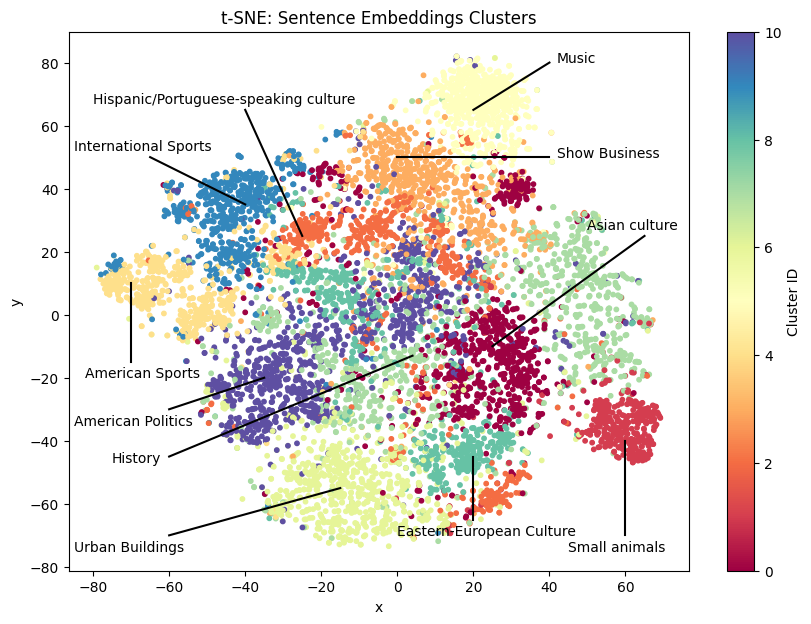

In [199]:
# Visualization
plt.figure(figsize=(10, 7))

# Clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Spectral', s=10)
plt.title('t-SNE: Sentence Embeddings Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(scatter, label='Cluster ID')

# Description
plt.plot([25, 65], [-10, 25], 'k-')
plt.annotate('Asian culture', xy=(50, 27))
plt.plot([60, 60], [-70, -40],'k-')
plt.annotate('Small animals', xy=(45, -75))
plt.plot([-40, -25], [65, 25],'k-')
plt.annotate('Hispanic/Portuguese-speaking culture', xy=(-80, 67))
plt.plot([0, 40], [50, 50],'k-')
plt.annotate('Show Business', xy=(42, 50))
plt.plot([-70, -70], [-15, 10],'k-')
plt.annotate('American Sports', xy=(-82, -20))
plt.plot([20, 40], [65, 80],'k-')
plt.annotate('Music', xy=(42, 80))
plt.plot([-60, -15], [-70, -55],'k-')
plt.annotate('Urban Buildings', xy=(-85, -75))
plt.plot([-60, 4], [-45, -13],'k-')
plt.annotate('History', xy=(-75, -47))
plt.plot([20, 20], [-45, -65],'k-')
plt.annotate('Eastern-European Culture', xy=(0, -70))
plt.plot([-65, -40], [50, 35],'k-')
plt.annotate('International Sports', xy=(-85, 52))
plt.plot([-60, -35], [-30, -20],'k-')
plt.annotate('American Politics', xy=(-85, -35))
plt.show()

### DBSCAN

### Latent Dirichlet Allocation (LDA)

## Evaluation and Interpretation

## End